# AWPS - Aguirre's Wager Point System

## Description & Inspiration

Below I implement a closed point rating system. I’ll define a “closed point” rating system to be a rating system that distributes a finite number of points to all players in the MLB. These points will be transferred between pitchers and batters each time a pitcher and batter face off.

I was inspired to create this rating system by the Hungarian-American physicist Arpad Elo who invented the Elo Rating System. His system was used to rate chess players based on their relative skill levels. I expect that the Elo Rating System was a bit simpler to implement because the points were transferred between two players who played the same position (both are chess players). The point system I am implementing will be transferring points between two players who play different positions - pitcher and batter, and will have to take into account different events.


## AWPS can replace some metrics

AWPS takes into account singles, doubles, triples, homeruns, and strikeouts. For Batters this means it could replace batting avg, and slugging percentage. AWPS weights homeruns higher than singles, doubles, and triples. The issue with this is that it does not take into account at bats. So AWPS doesn't give a very accurate picture of a players entire career.

What AWPS is good at, is giving an decent representation of a players performance over a season. What AWPS is great at is giving an accurate representation of a players recent performance. AWPS changes quickly as a result of wins losses to between a pitcher and batter. The more you lose points, the faster you lose points. This is because AWPS weights the number of points a player gains depending on the number of points they already have.

Another benefit to AWPS over batting avg, or slugging percentage, is that it weights the number of points between each face off, by the skill level of the players involved. That means if a great batter gets a lot of hits from a crappy pitcher, their AWPS score won't inflate. However, if a batter is on a bad streak due to an injury or some unseen problem, they will lose points quickly if they are getting "beat by a bad pitcher".

## Set up env

In [1]:
# import libs
from pybaseball import statcast
from pybaseball.lahman import *
from pybaseball.team_batting import *
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm 

from Helpers import get_statcast_data, get_player_map

In [2]:
# import data
data = get_statcast_data('../data', 2017)
data18 = get_statcast_data('../data', 2018)

In [3]:
# create player_map
unique_ids = unique_ids = list(map(int, list(set(
    list(data.pitcher.unique()) + list(data.batter.unique()) +\
    list(data18.pitcher.unique()) + list(data18.batter.unique())
))))
player_map = get_player_map(unique_ids, '../data/master.csv')

In [4]:
imgdir = '../docs/img'

## Create helper functions

In [5]:
def event_map(e):
    """
    Map a string from the statcast database events column to a key
    @param e str which is a value from the events column
    @return str|int (h, hr, k) | -1
    """
    emap = {
        'single': 'h',
        'double': 'h',
        'triple': 'h',
        'home_run': 'hr',
        'strikeout': 'k'
    }
    if e in emap:
        return emap[e]
    else:
        return -1

def get_proba_function(df):
    """
    Create a function which produces the probability of: a hit (excluding homerun), homerun, and strike
    @param df pandas.DataFrame which has a years seasons worth of statcast data
    @return a function which takes in an event (h, hr, k), and returns a probability of the event
    """
    n_1b = len(df.loc[df.events == 'single'])
    n_2b = len(df.loc[df.events == 'double'])
    n_3b = len(df.loc[df.events == 'triple'])
    n_hr = len(df.loc[df.events == 'home_run'])
    n_so = len(df.loc[df.events == 'strikeout'])
    n_bb = len(df.loc[df.events == 'walk'])
    emap = { 'h': n_1b + n_2b + n_3b, 'hr': n_hr, 'k': n_so }
    return lambda e: emap[e] / sum(list(emap.values()))

def wager(p, b, k):
    """
    Calculates the points a pitcher, and a batter should wager on a given event
    @param p float: score of pitcher
    @param b float: score of batter
    @param k int: wager factor, weights how much players should wager
    @return touple (float, float): (pitchers wager, batters wager)
    """
    ep = (10**(p/400))/((10**(p/400)) + (10**(b/400)))
    eb = 1-ep
    return (round(k(p)*ep, 3), round(k(b)*eb, 3))

def get_assign_points_function(pf):
    """
    @param pf float: probability function of an event
    @return function which takes (p, b, e, f) as args
    """
    def assign_points_function(p, b, e, k):
        """
        @param p float: score of pitcher
        @param b float: score of batter
        @param e str[] | str: event (h | hr | k)
        @param k int: wager factor, weights how much players should wager
        @return tuple (float, float) which contains (pitchers new points, batters new points)
        """
        pw, bw = wager(p, b, k)
        if type(e) == str:
            event = e
        else:
            event = e.pop(0)
        proba = pf(event)
        points = (None, None)
        if event == 'k':
            percent = 1 - (proba)
            points = (p+(bw*percent), b-(bw*percent))
        elif event == 'h':
            percent = (1 - (pf('h') + pf('hr')))/(pf('h')/pf('hr'))
            points = (p-(bw*percent), b+(bw*percent))
        elif event == 'hr':
            percent = (1 - (pf('h') + pf('hr')))*(pf('h')/pf('hr'))
            points = (p-(bw*percent), b+(bw*percent))
        points = (round(points[0], 3), round(points[1], 3))
        if type(e) == str or len(e) == 0:
            return points
        else:
            return assign_points_function(points[0], points[1], e, f)
    return assign_points_function

def k_function(p):
    """
    @param p float which is the number of points a player has
    @ return float which is the k multiplier for how much a player should wager
    """
    res = np.exp(3600/(p))
    if res >= 20:
        return 20*2
    elif res <= 10:
        return 10*2
    else:
        return res*2
    
def history_avg(arr, n):
    """
    @param arr list which contains floats 
    @param n int specifying how far back to average (window)
    @return average from window length n to end of arr
    """
    l = len(arr)
    if n > l:
        n = l
    return np.mean(arr[-n:])

def running_mean(arr, N):
    """
    @param arr list
    @param N int
    @return running mean with window n and length len(arr)
    """
    cumsum = np.cumsum(np.insert(arr, 0, 0))
    return (cumsum[N:] - cumsum[:-N]) / float(N)

## K Function

In the Elo rating system the [**k factor**](https://en.wikipedia.org/wiki/Elo_rating_system#Most_accurate_K-factor) is a number used in the calculation of how many points a player should wager. There is some theoretical research on the best k factors to use, but many different organizations in chess use different k factor values.

Typically the k factor is staggered at different values for different ranges of players. I have chosen to create a function that changes the k factor with the number of points a player has. I based this function off of the range described by [Jeff Sonas](https://en.wikipedia.org/wiki/Jeff_Sonas).

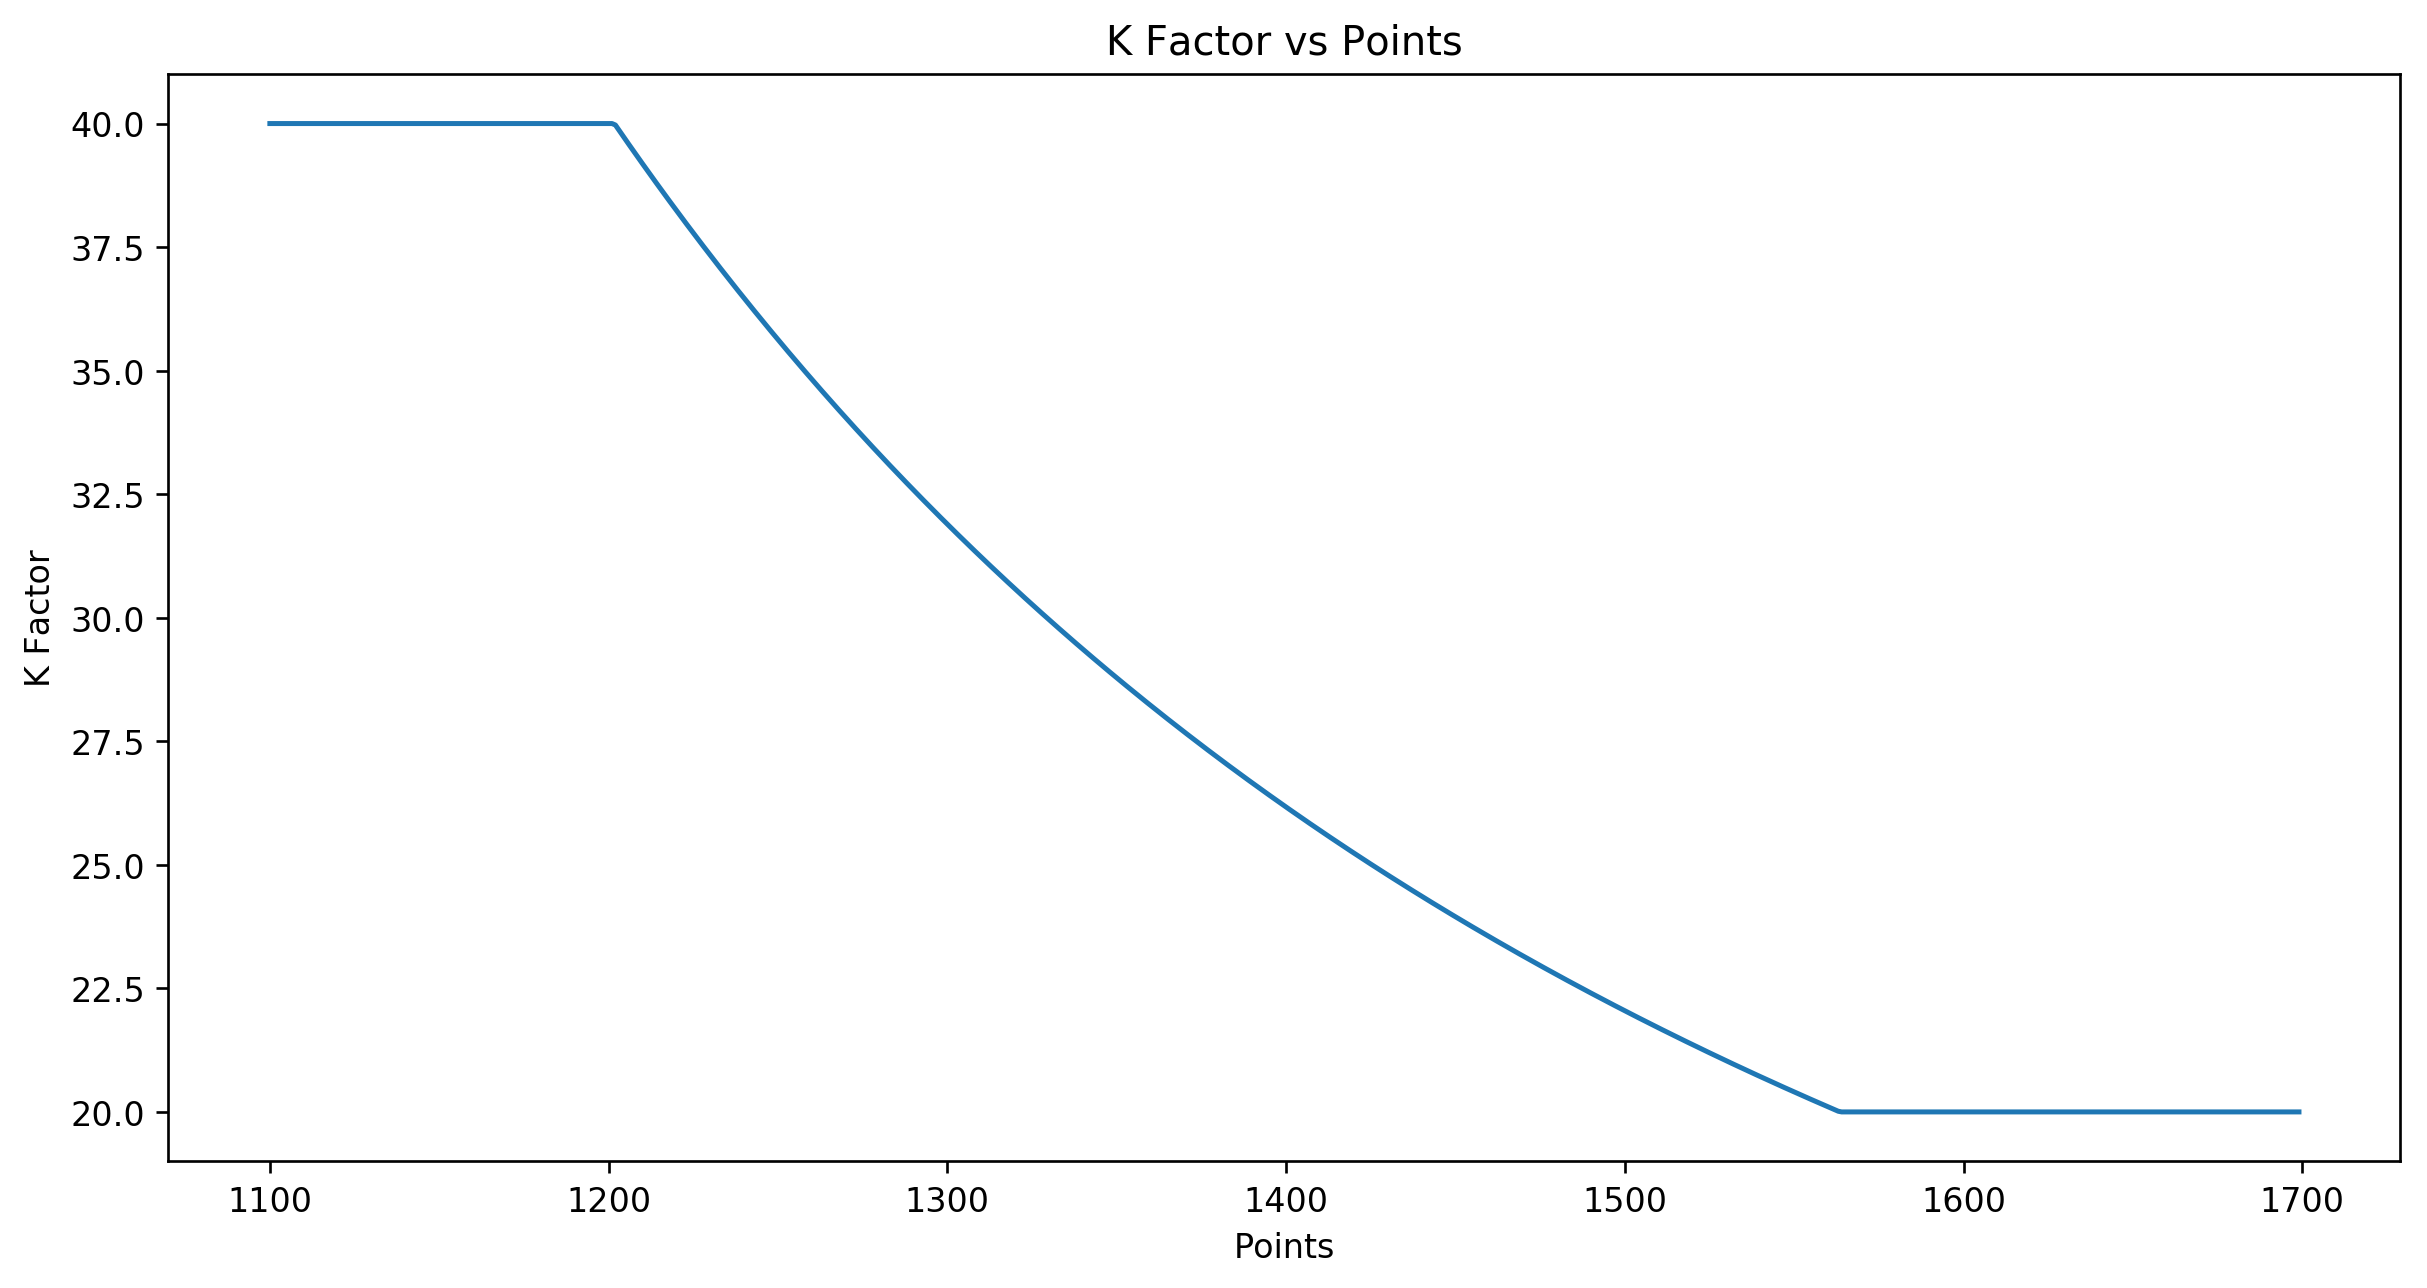

In [6]:
# view of the k_function

r = list(range(1100, 1700))
vals = list(map(k_function, r))
plt.figure(num=None, figsize=(12, 6), dpi=240, facecolor='w', edgecolor='k')
plt.plot(r, vals)
plt.title("K Factor vs Points")
plt.xlabel("Points")
plt.ylabel("K Factor")
plt.savefig(os.path.join(imgdir, 'KFactor'))
plt.show()

## Define constants

In [7]:
# factor to weight how much points should be wagered in an event
wf = k_function
# event probability function
epf = get_proba_function(data)
# assign points function
update_score = get_assign_points_function(epf)
# history: how far back to avg a score (prevents sensitivity to local events)
h = 5

## Examples of how functions work

### Event Probability Function

In [8]:
print('probability of a hit (includes single, double, triple) is', epf('h'))
print('probability of a homerun is', epf('hr'))
print('probability of a strikeout is', epf('k'))
print('sum: ', epf('h') + epf('hr') + epf('k'))

probability of a hit (includes single, double, triple) is 0.4366820362349215
probability of a homerun is 0.07416981044199153
probability of a strikeout is 0.489148153323087
sum:  1.0


In [9]:
epf('h')/epf('hr')

5.887598116169544

### Wager Function

The following examples will show the properties of the wager function.

1. If two players have the same amount of points, they will wager a constant number of points (which depends on the wager factor) no matter how high or low thier points are compared to other players.
2. The amount of points wagered depends on the difference in skill level. The bigger the gap, the more points will be wagered by each player.

The format of the following example are {player#}:{points}:{wager}, example => {p1:1500:5}

In [10]:
p1, p2 = 1500, 1500
p1w, p2w = wager(p1, p2, wf)
print('SAME number of points => (p1:{}:{}, p2:{}:{})'
      .format(p1, p1w, p2, p2w))

p1, p2 = 1300, 1300
p1w, p2w = wager(p1, p2, wf)
print('SAME number of points => (p1:{}:{}, p2:{}:{})'
      .format(p1, p1w, p2, p2w))

p1, p2 = 1400, 1500
p1w, p2w = wager(p1, p2, wf)
print('DIFFERENT number of points SMALL GAP => (p1:{}:{}, p2:{}:{})'
      .format(p1, p1w, p2, p2w))

p1, p2 = 1000, 1700
p1w, p2w = wager(p1, p2, wf)
print('DIFFERENT number of points LARGE GAP => (p1:{}:{}, p2:{}:{})'
      .format(p1, p1w, p2, p2w))

SAME number of points => (p1:1500:11.023, p2:1500:11.023)
SAME number of points => (p1:1300:15.946, p2:1300:15.946)
DIFFERENT number of points SMALL GAP => (p1:1400:9.419, p2:1500:14.111)
DIFFERENT number of points LARGE GAP => (p1:1000:0.699, p2:1700:19.651)


### Update Score Function (or Assign Points Function)

The sum below should ideally come out to be 0.

In [11]:
# pitcher who is pitching
pitcher = 1500
# list of batters up to bat with the result of each event
batter = 1500

batter_event = ['k']*489 + ['h']*436 + ['hr']*74
res = [0]*len(batter_event)
for i in range(len(batter_event)):
    event = batter_event[i]
    _, res[i] = update_score(pitcher, batter, event, wf)
    res[i] = res[i] - 1500
print('sum: ', sum(res))
vals, counts = np.unique(batter_event, return_counts=True)
for i in range(len(counts)):
    print(vals[i], counts[i]/sum(counts))

sum:  -5.0530000000053406
h 0.4364364364364364
hr 0.07407407407407407
k 0.4894894894894895


## Running the algorithm

+ Initialize by giving every player the same number of points (e.g., 1500 points) at the start of a some season.
+ Before each event (single, double, triple, hr, k), compute how much each player will wager based on their skill levels. The player with the higher skill level will wager more points than a player with less points.
+ After each event, depending on the probability of the event, compute how much of the wagered points will be transferred to the other player.


### 2017 Season Data

In [12]:
point_df = data.loc[:, ('game_date', 'game_pk', 'sv_id', 'pitcher', 'batter', 'events')].copy()
points_df = point_df.sort_values(['game_date', 'sv_id'])
pitchers = { int(p): [1500.0] for p in point_df.pitcher.unique()}
batters = { int(b): [1500.0] for b in point_df.batter.unique()}

In [13]:
for row in point_df.iterrows():
    row = row[1]
    event = event_map(row.events)
    if event != -1:
        p_id = int(row.pitcher)
        b_id = int(row.batter)
        update = update_score(history_avg(pitchers[p_id], h), history_avg(batters[b_id], h), event, wf)
        pitchers[p_id].append(update[0])
        batters[b_id].append(update[1])

In [14]:
# sort the batters and pitchers by thier final scores
batters_sorted = sorted([(k, v[-1]) for k, v in batters.items()], key=lambda x: x[1])
pitchers_sorted = sorted([(k, v[-1]) for k, v in pitchers.items()], key=lambda x: x[1])

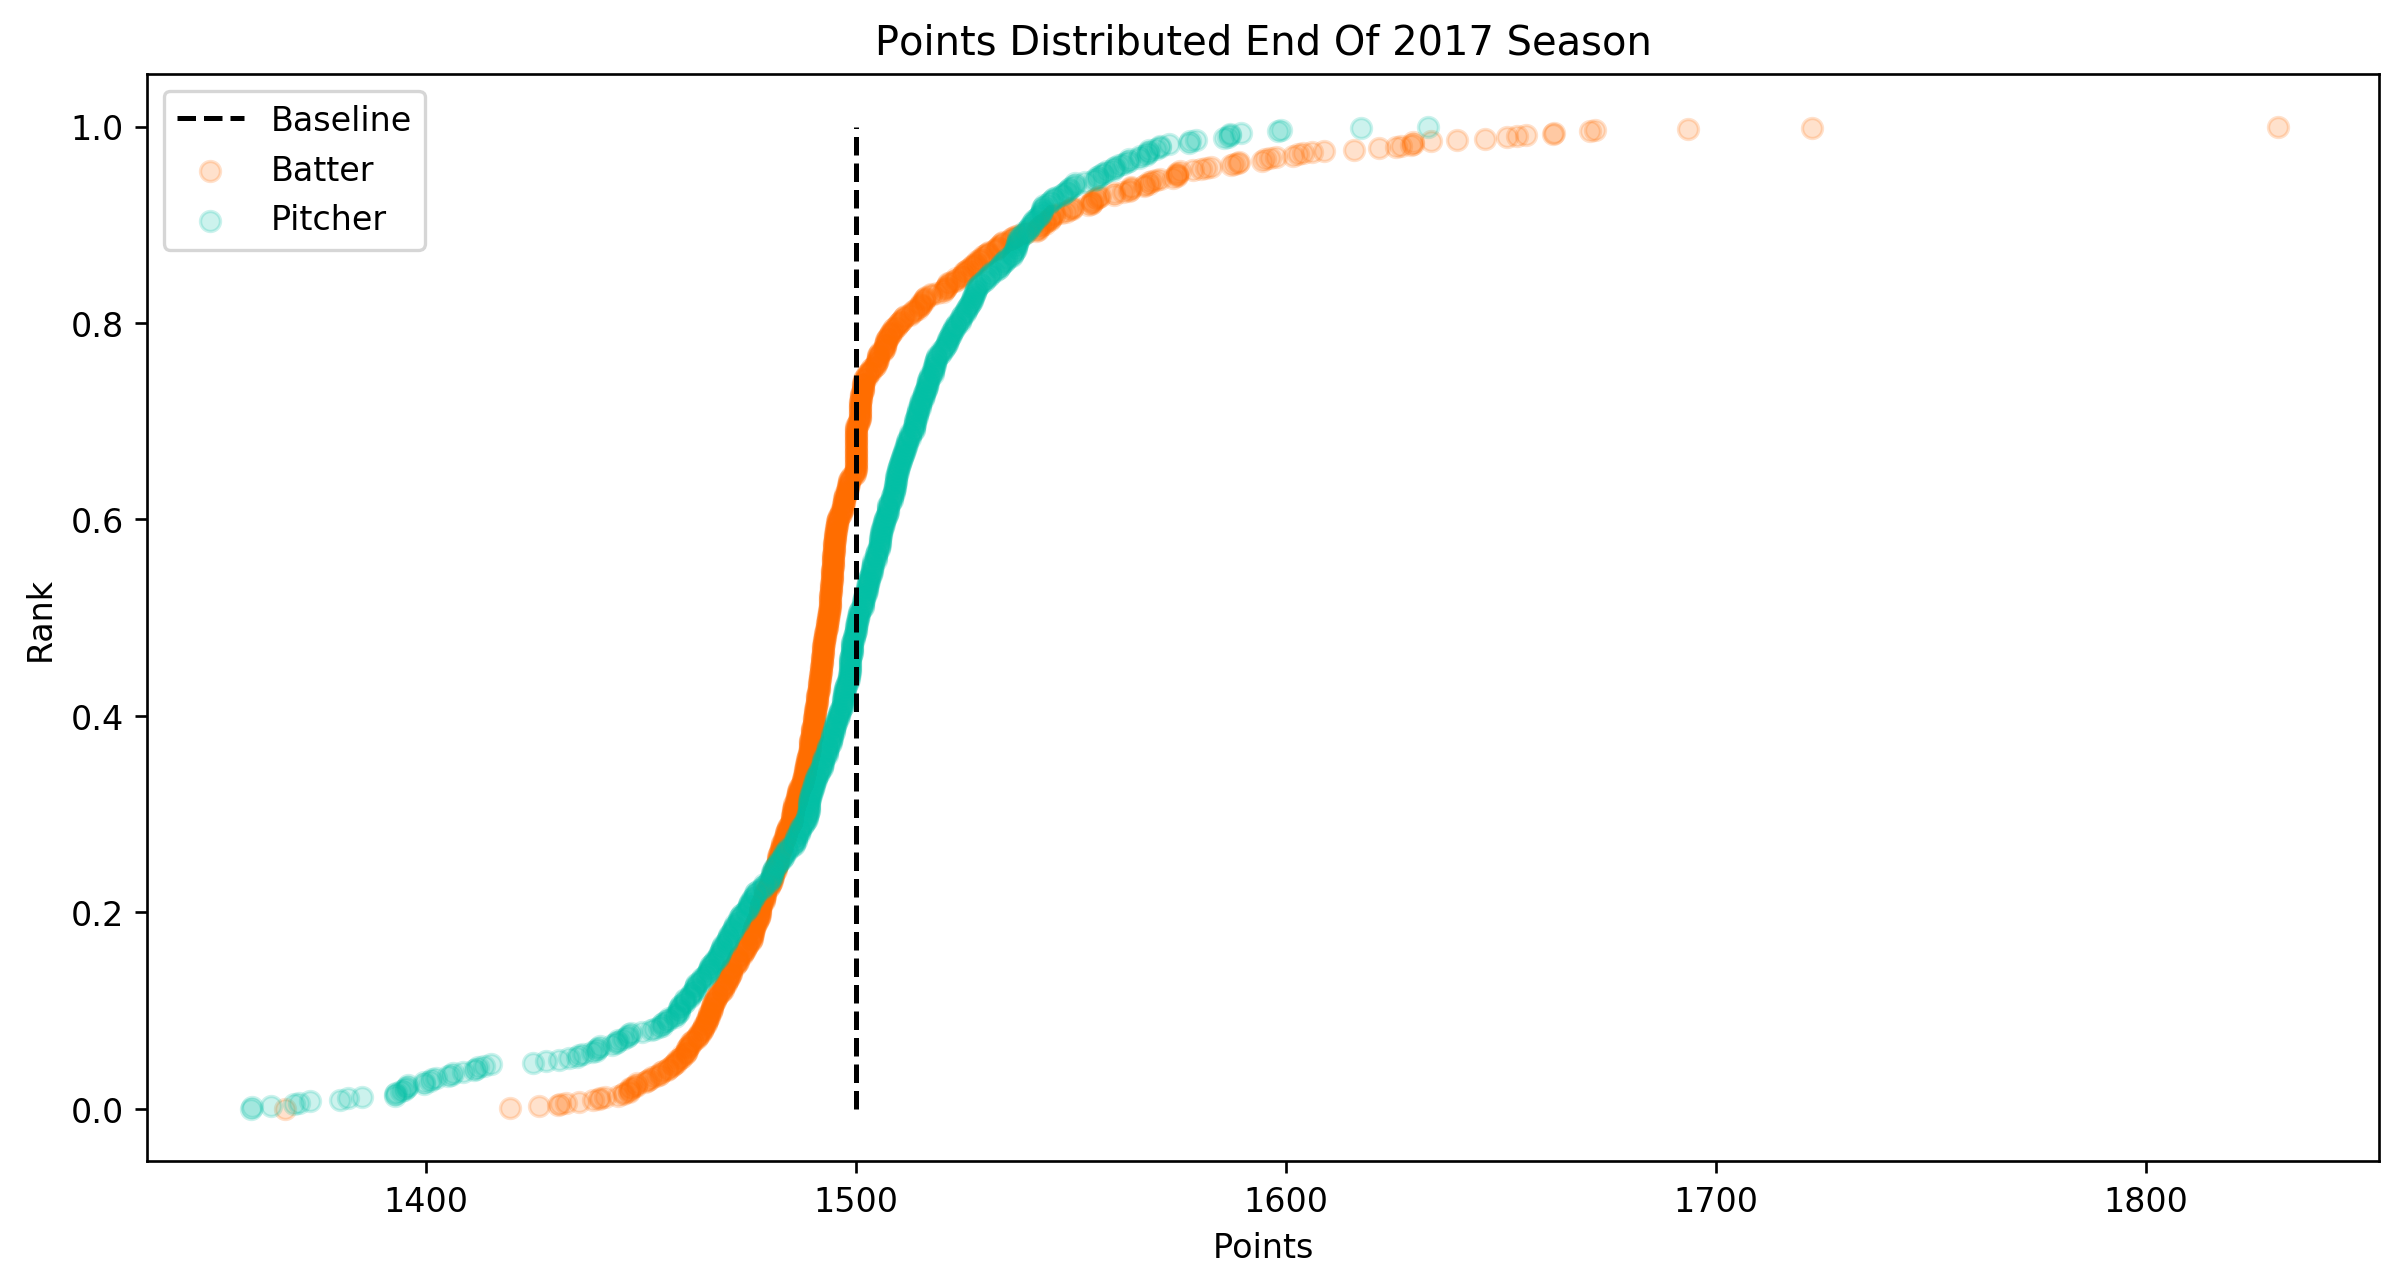

In [15]:
# plot the final points of all players
plt.figure(num=None, figsize=(12, 6), dpi=240, facecolor='w', edgecolor='k')
plt.scatter(np.array(batters_sorted)
            .transpose()[1], np.linspace(0, 1, len(batters_sorted)), color='#FF6D00', alpha=.2, label='Batter')
plt.scatter(np.array(pitchers_sorted)
            .transpose()[1], np.linspace(0, 1, len(pitchers_sorted)), color='#00BFA5', alpha=.2, label='Pitcher')
plt.plot([1500]*2, [0, 1], color='black', linestyle='dashed', label='Baseline')
plt.title('Points Distributed End Of 2017 Season')
plt.ylabel('Rank')
plt.xlabel('Points')
plt.legend()
plt.savefig(os.path.join(imgdir, 'PointsDistributed2017'))
plt.show()

### 2018 Season Data

In [16]:
point_df = data18.loc[:, ('game_date', 'game_pk', 'sv_id', 'pitcher', 'batter', 'events')].copy()
points_df = point_df.sort_values(['game_date', 'sv_id'])
pitchers = { int(p): [1500.0]
            for p in point_df.pitcher.unique()}
batters = { int(b): [1500.0]
           for b in point_df.batter.unique()}

In [17]:
for row in point_df.iterrows():
    row = row[1]
    event = event_map(row.events)
    if event != -1:
        p_id = int(row.pitcher)
        b_id = int(row.batter)
        update = update_score(history_avg(pitchers[p_id], h), history_avg(batters[b_id], h), event, wf)
        pitchers[p_id].append(update[0])
        batters[b_id].append(update[1])

In [18]:
# sort the batters and pitchers by thier final scores
batters_sorted = sorted([(k, v[-1]) for k, v in batters.items()], key=lambda x: x[1])
pitchers_sorted = sorted([(k, v[-1]) for k, v in pitchers.items()], key=lambda x: x[1])

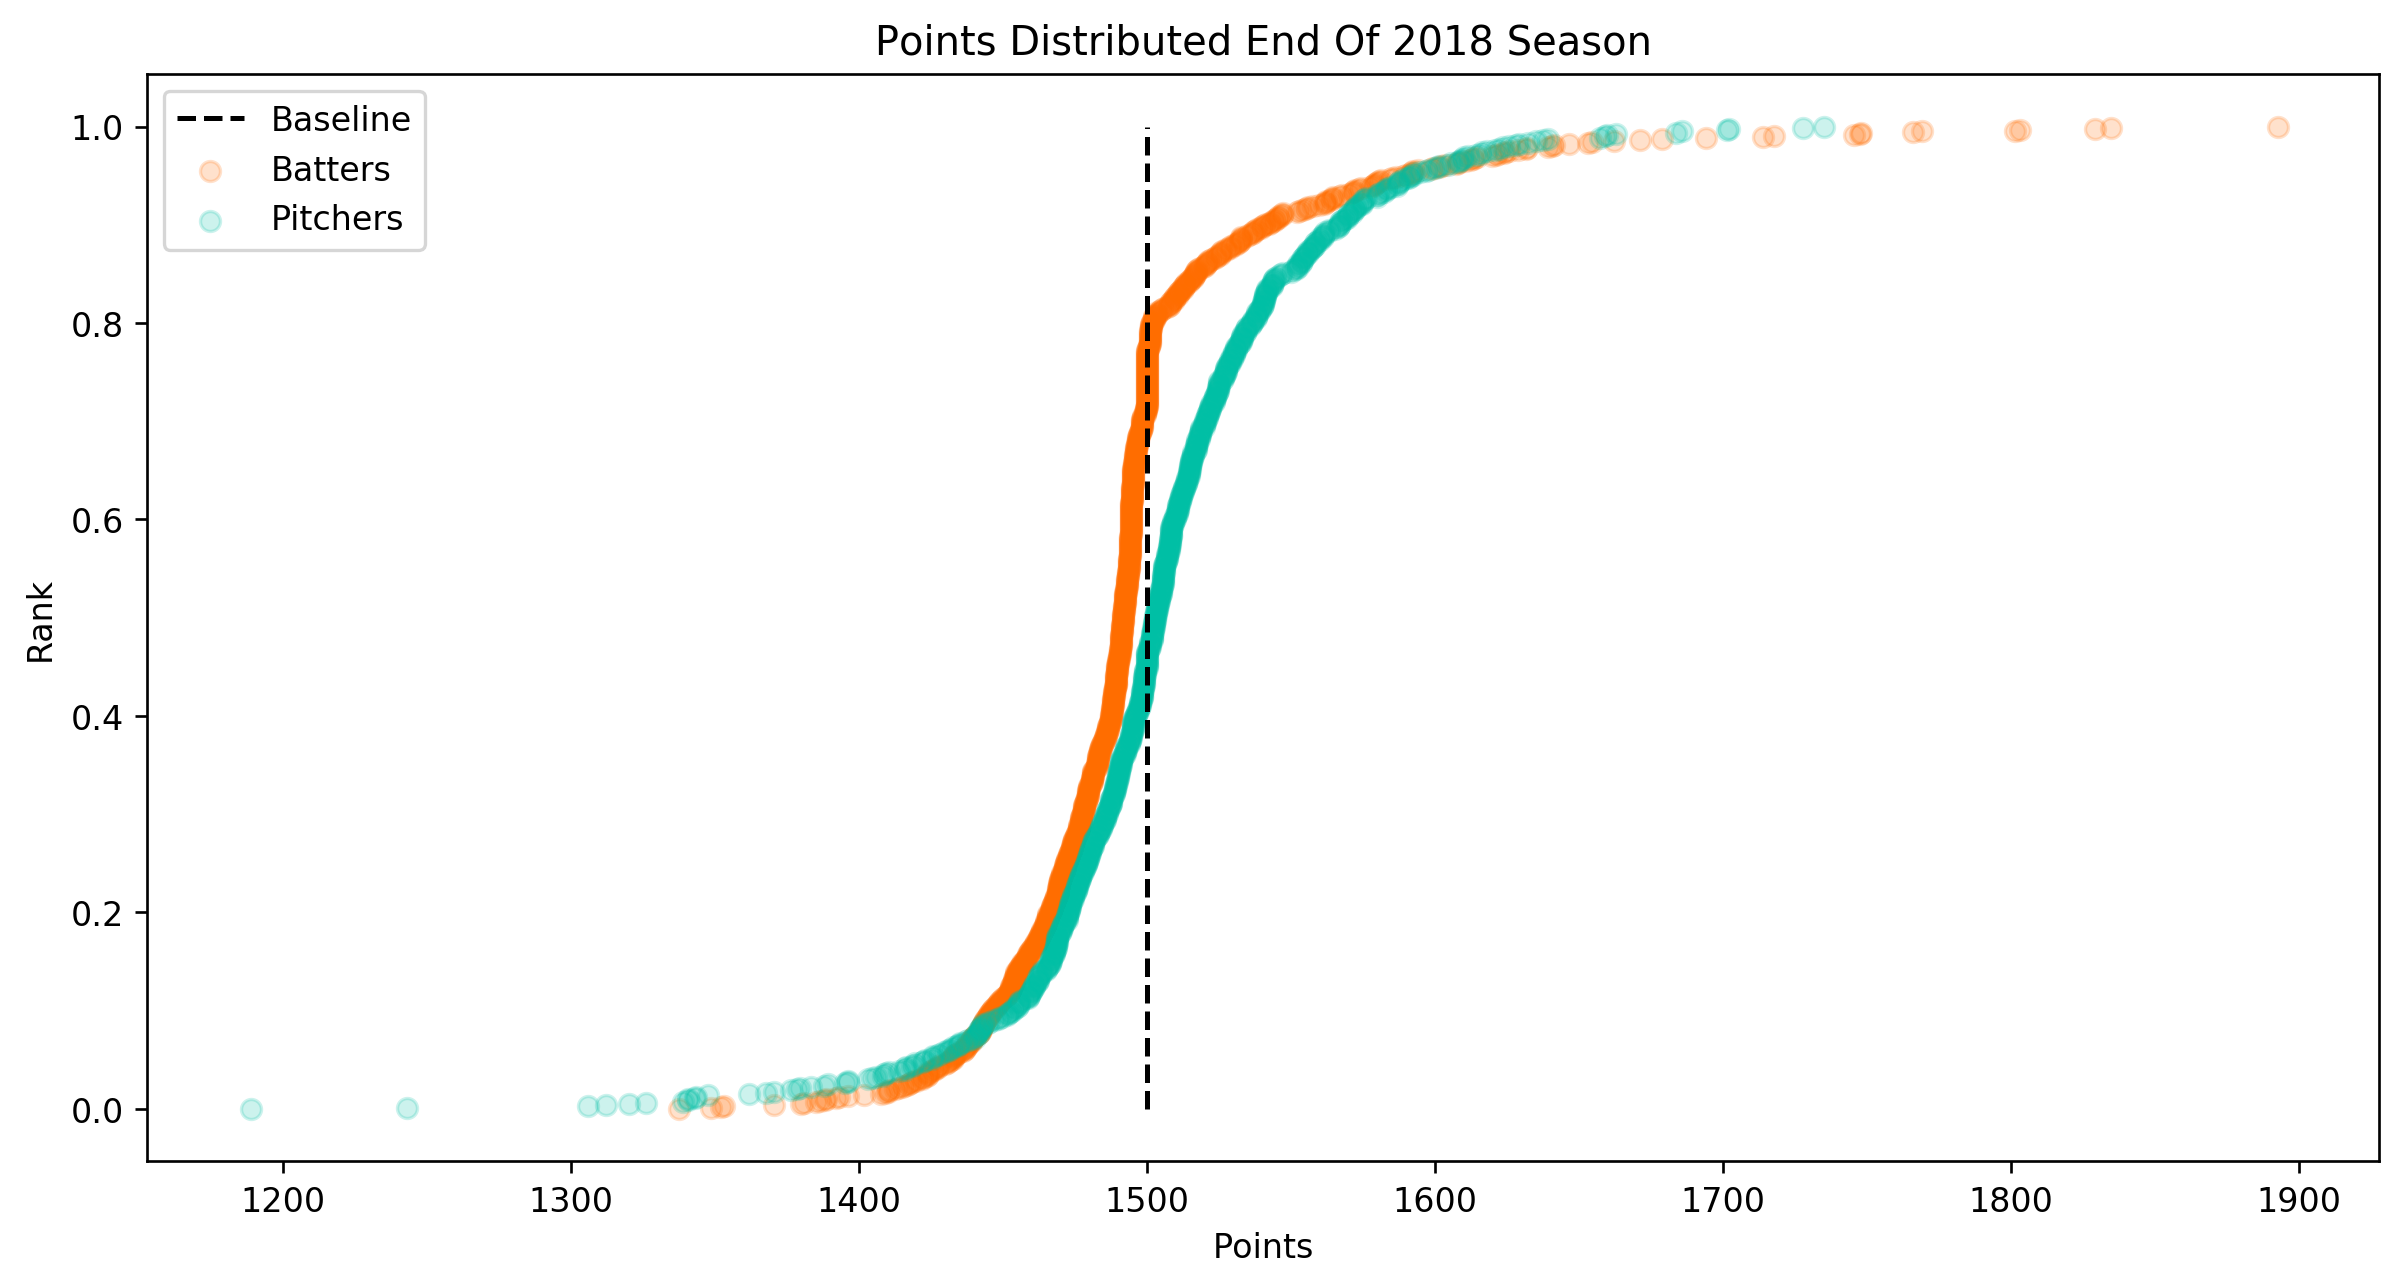

In [24]:
# plot the final points of all players
plt.figure(num=None, figsize=(12, 6), dpi=240, facecolor='w', edgecolor='k')
plt.scatter(np.array(batters_sorted)
            .transpose()[1], np.linspace(0, 1, len(batters_sorted)), color='#FF6D00', alpha=.2, label='Batters')
plt.scatter(np.array(pitchers_sorted)
            .transpose()[1], np.linspace(0, 1, len(pitchers_sorted)), color='#00BFA5', alpha=.2, label='Pitchers')

plt.plot([1500]*2, [0, 1], color='black', linestyle='dashed', label='Baseline')

plt.title('Points Distributed End Of 2018 Season')
plt.ylabel('Rank')
plt.xlabel('Points')
plt.legend()
plt.savefig(os.path.join(imgdir, 'PointsDistributed2018'))
plt.show()

## Analyzing 2018 Data


### Top 5 Fangraph in AWPS

Below I plotted the AWPS values for the top 5 pitchers and top 5 batters according to fangraph. My metric seems to consitantly rank players at levels similar to fan graph. This means my metric might be useful in predicting players skill levels.

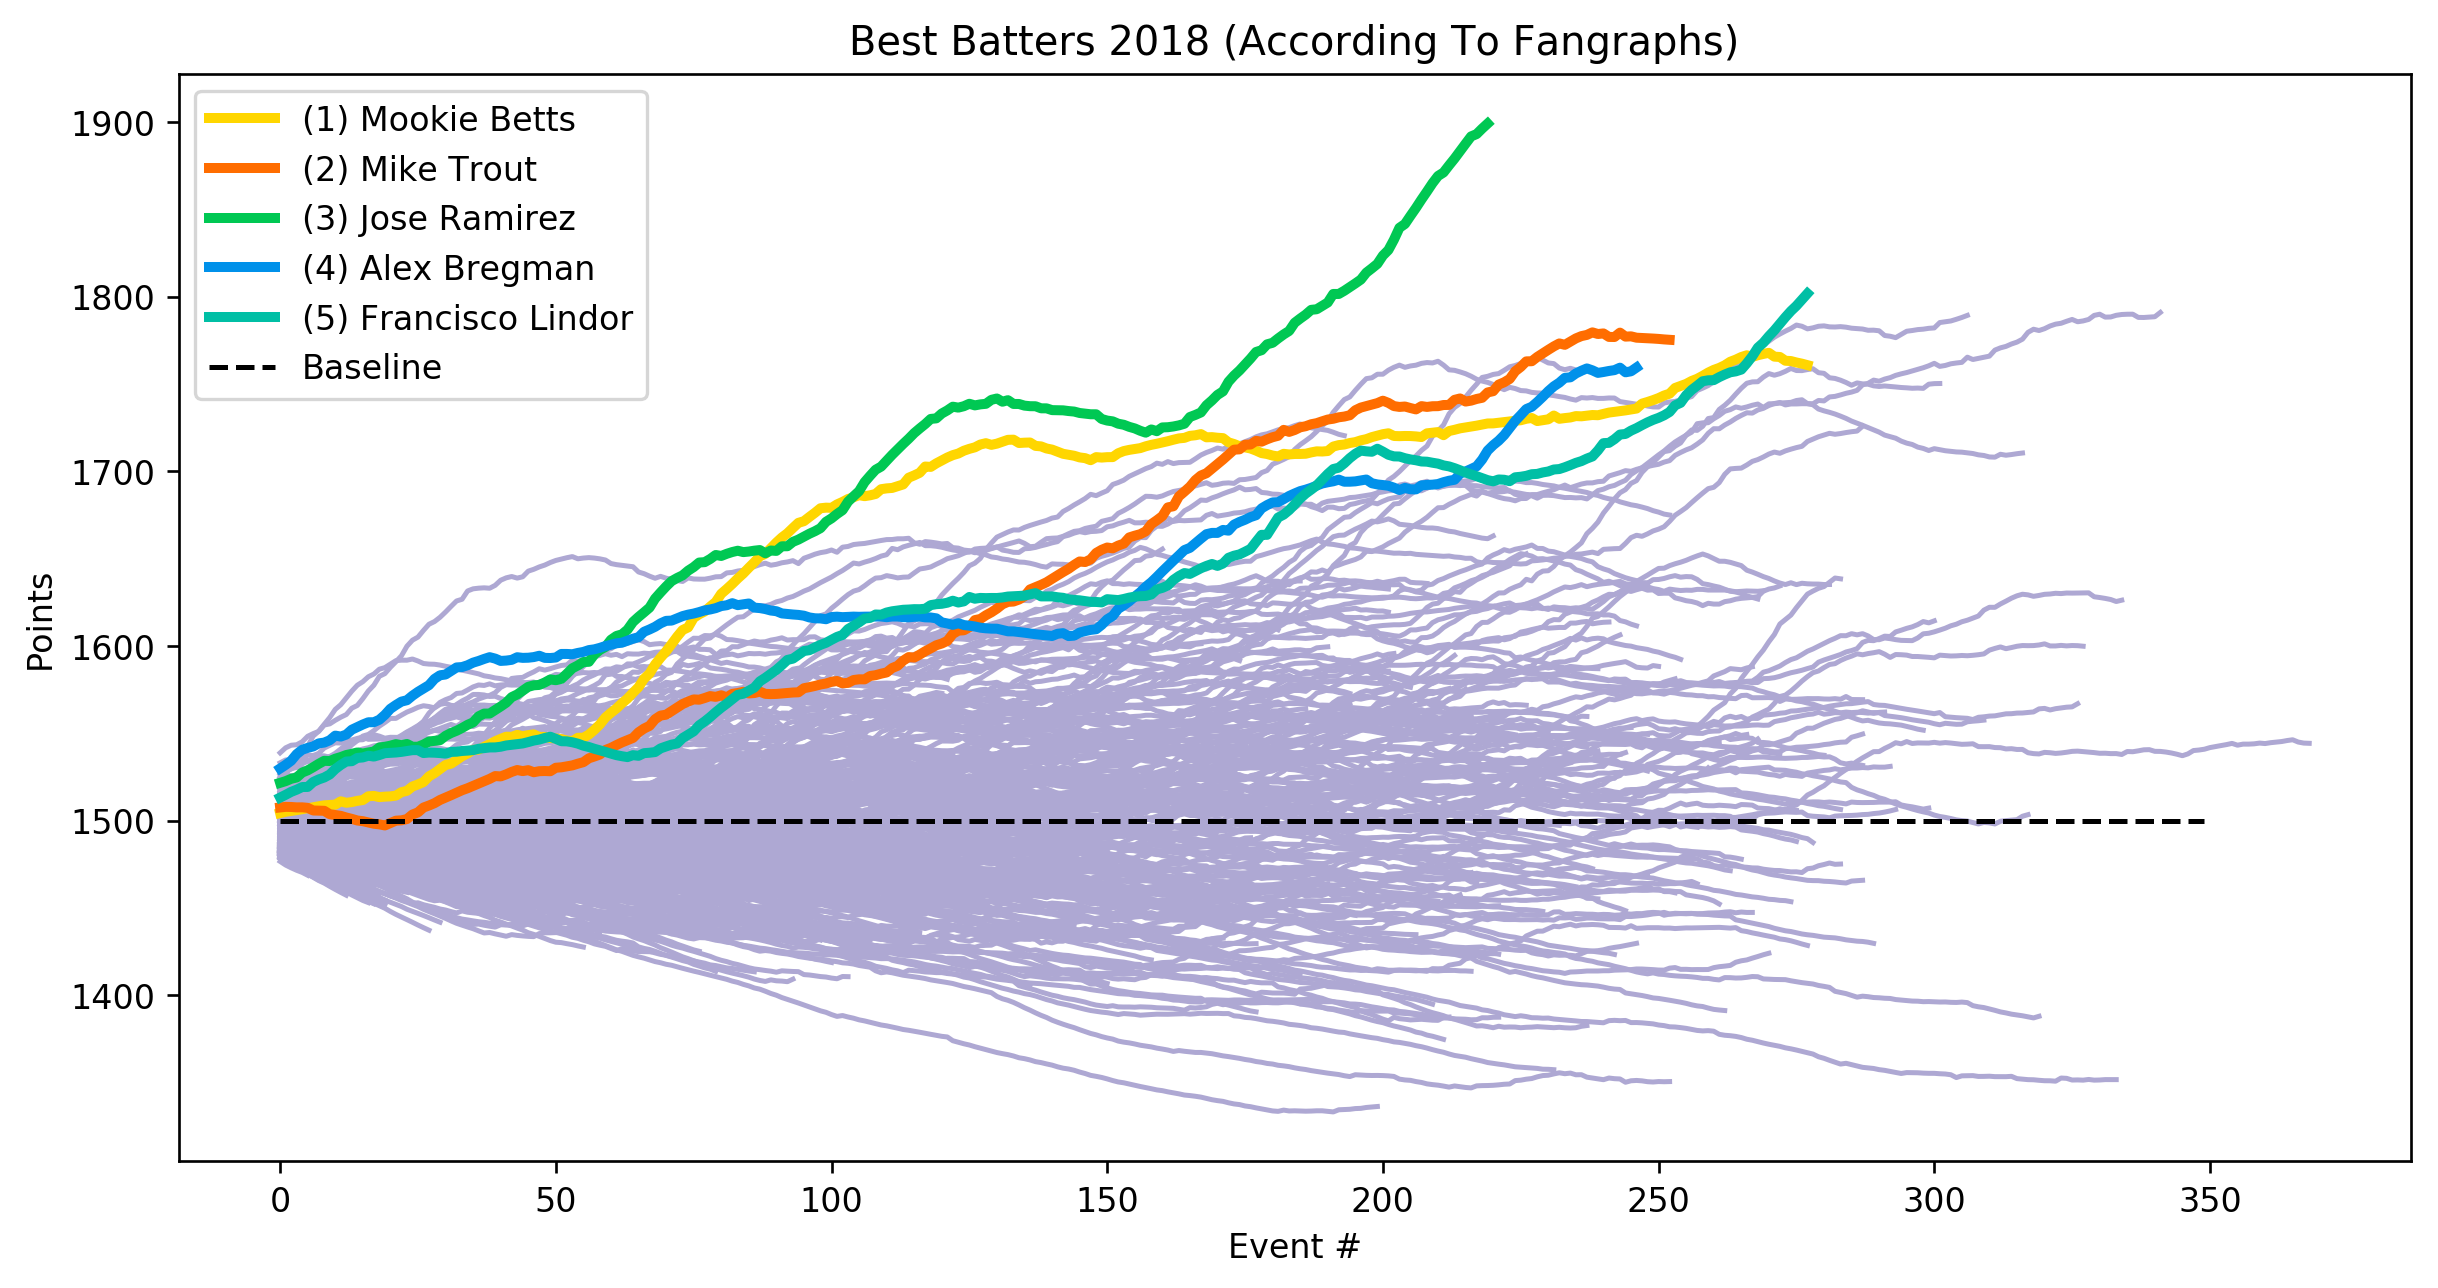

In [20]:
window = 20
plt.figure(num=None, figsize=(12, 6), dpi=240, facecolor='w', edgecolor='k')
for bid in batters:
    plt.plot(running_mean(batters[bid], window), color='#aea8d3')

bids = [605141, 545361, 608070, 608324, 596019]
labels = ['({}) {}'.format(str(i+1), player_map.get(bids[i])) for i in range(len(bids))]
colors = ['#FFD600', '#FF6D00', '#00C853', '#0091EA', '#00BFA5']

for i in range(len(bids)):
    plt.plot(running_mean(batters[bids[i]], window), label=labels[i], linewidth=3, color=colors[i])

plt.plot([1500]*350, color='black', linestyle='dashed', label='Baseline')
    
plt.title('Best Batters 2018 (According To Fangraphs)')
plt.xlabel('Event #')
plt.ylabel('Points')
plt.legend()
plt.savefig(os.path.join(imgdir, 'BestBattersVsAll'))
plt.show()

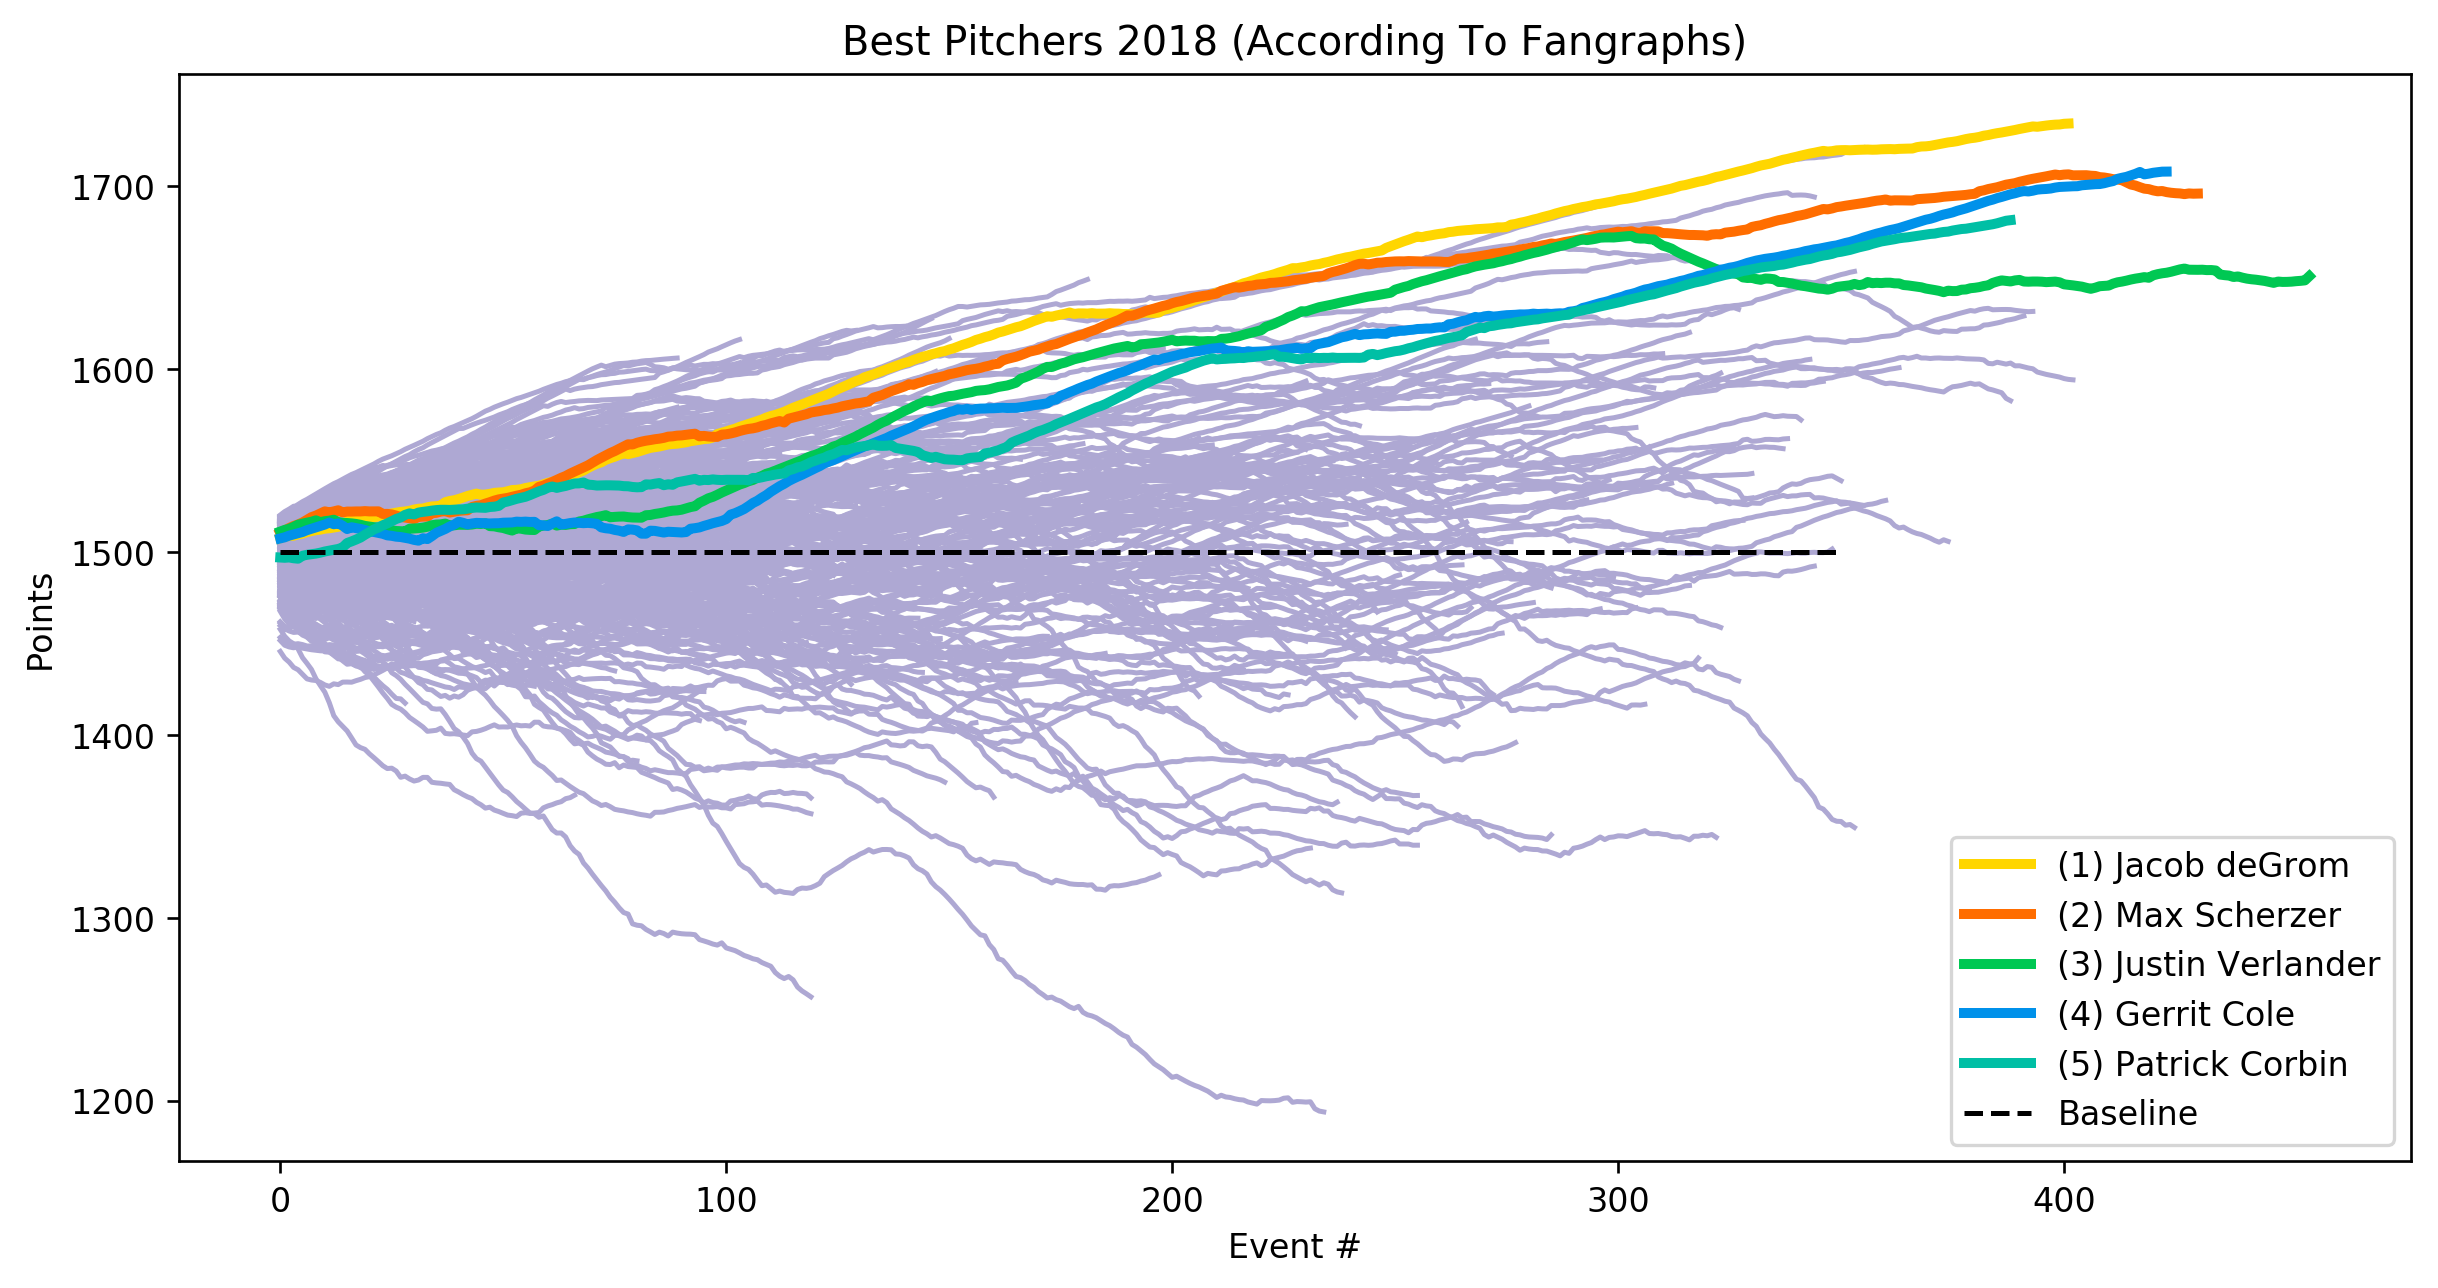

In [21]:
window = 20
plt.figure(num=None, figsize=(12, 6), dpi=240, facecolor='w', edgecolor='k')
for pid in pitchers:
    plt.plot(running_mean(pitchers[pid], window), color='#aea8d3')

pids = [594798, 453286, 434378, 543037, 571578]
labels = ['({}) {}'.format(str(i+1), player_map.get(pids[i])) for i in range(len(pids))]
colors = ['#FFD600', '#FF6D00', '#00C853', '#0091EA', '#00BFA5']

for i in range(len(bids)):
    plt.plot(running_mean(pitchers[pids[i]], window), label=labels[i], linewidth=3, color=colors[i])

plt.plot([1500]*350, color='black', linestyle='dashed', label='Baseline')
    
plt.title('Best Pitchers 2018 (According To Fangraphs)')
plt.xlabel('Event #')
plt.ylabel('Points')
plt.legend()
plt.savefig(os.path.join(imgdir, 'BestPitchersVsAll'))
plt.show()

### Top 5 Pitchers and Batters according to AWPS

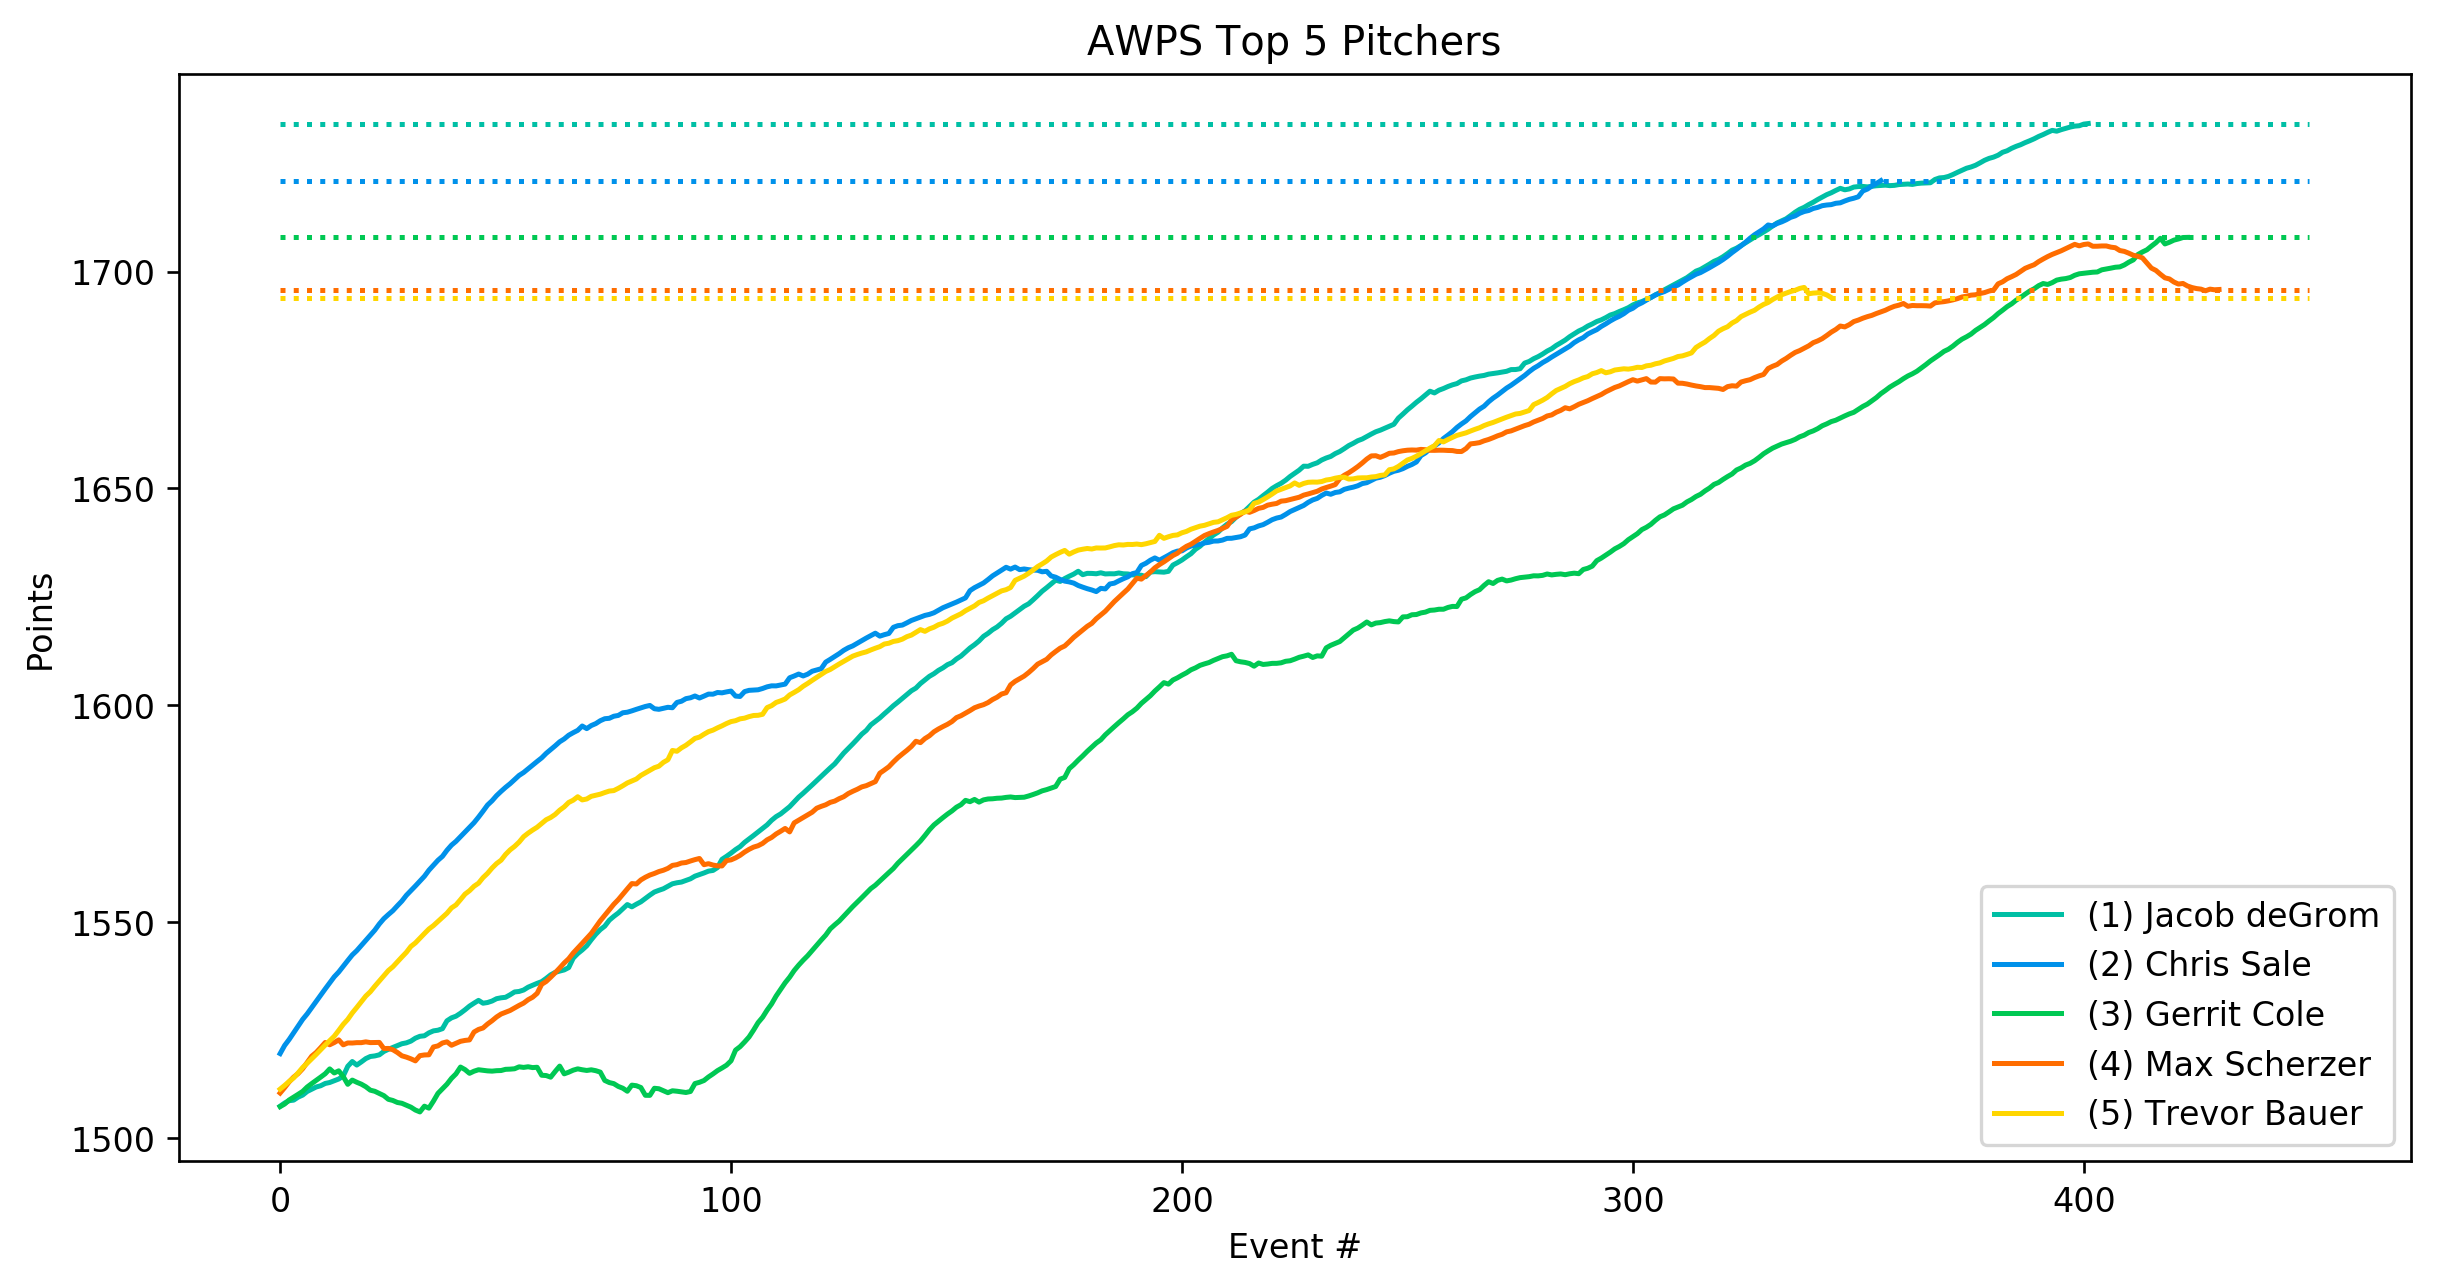

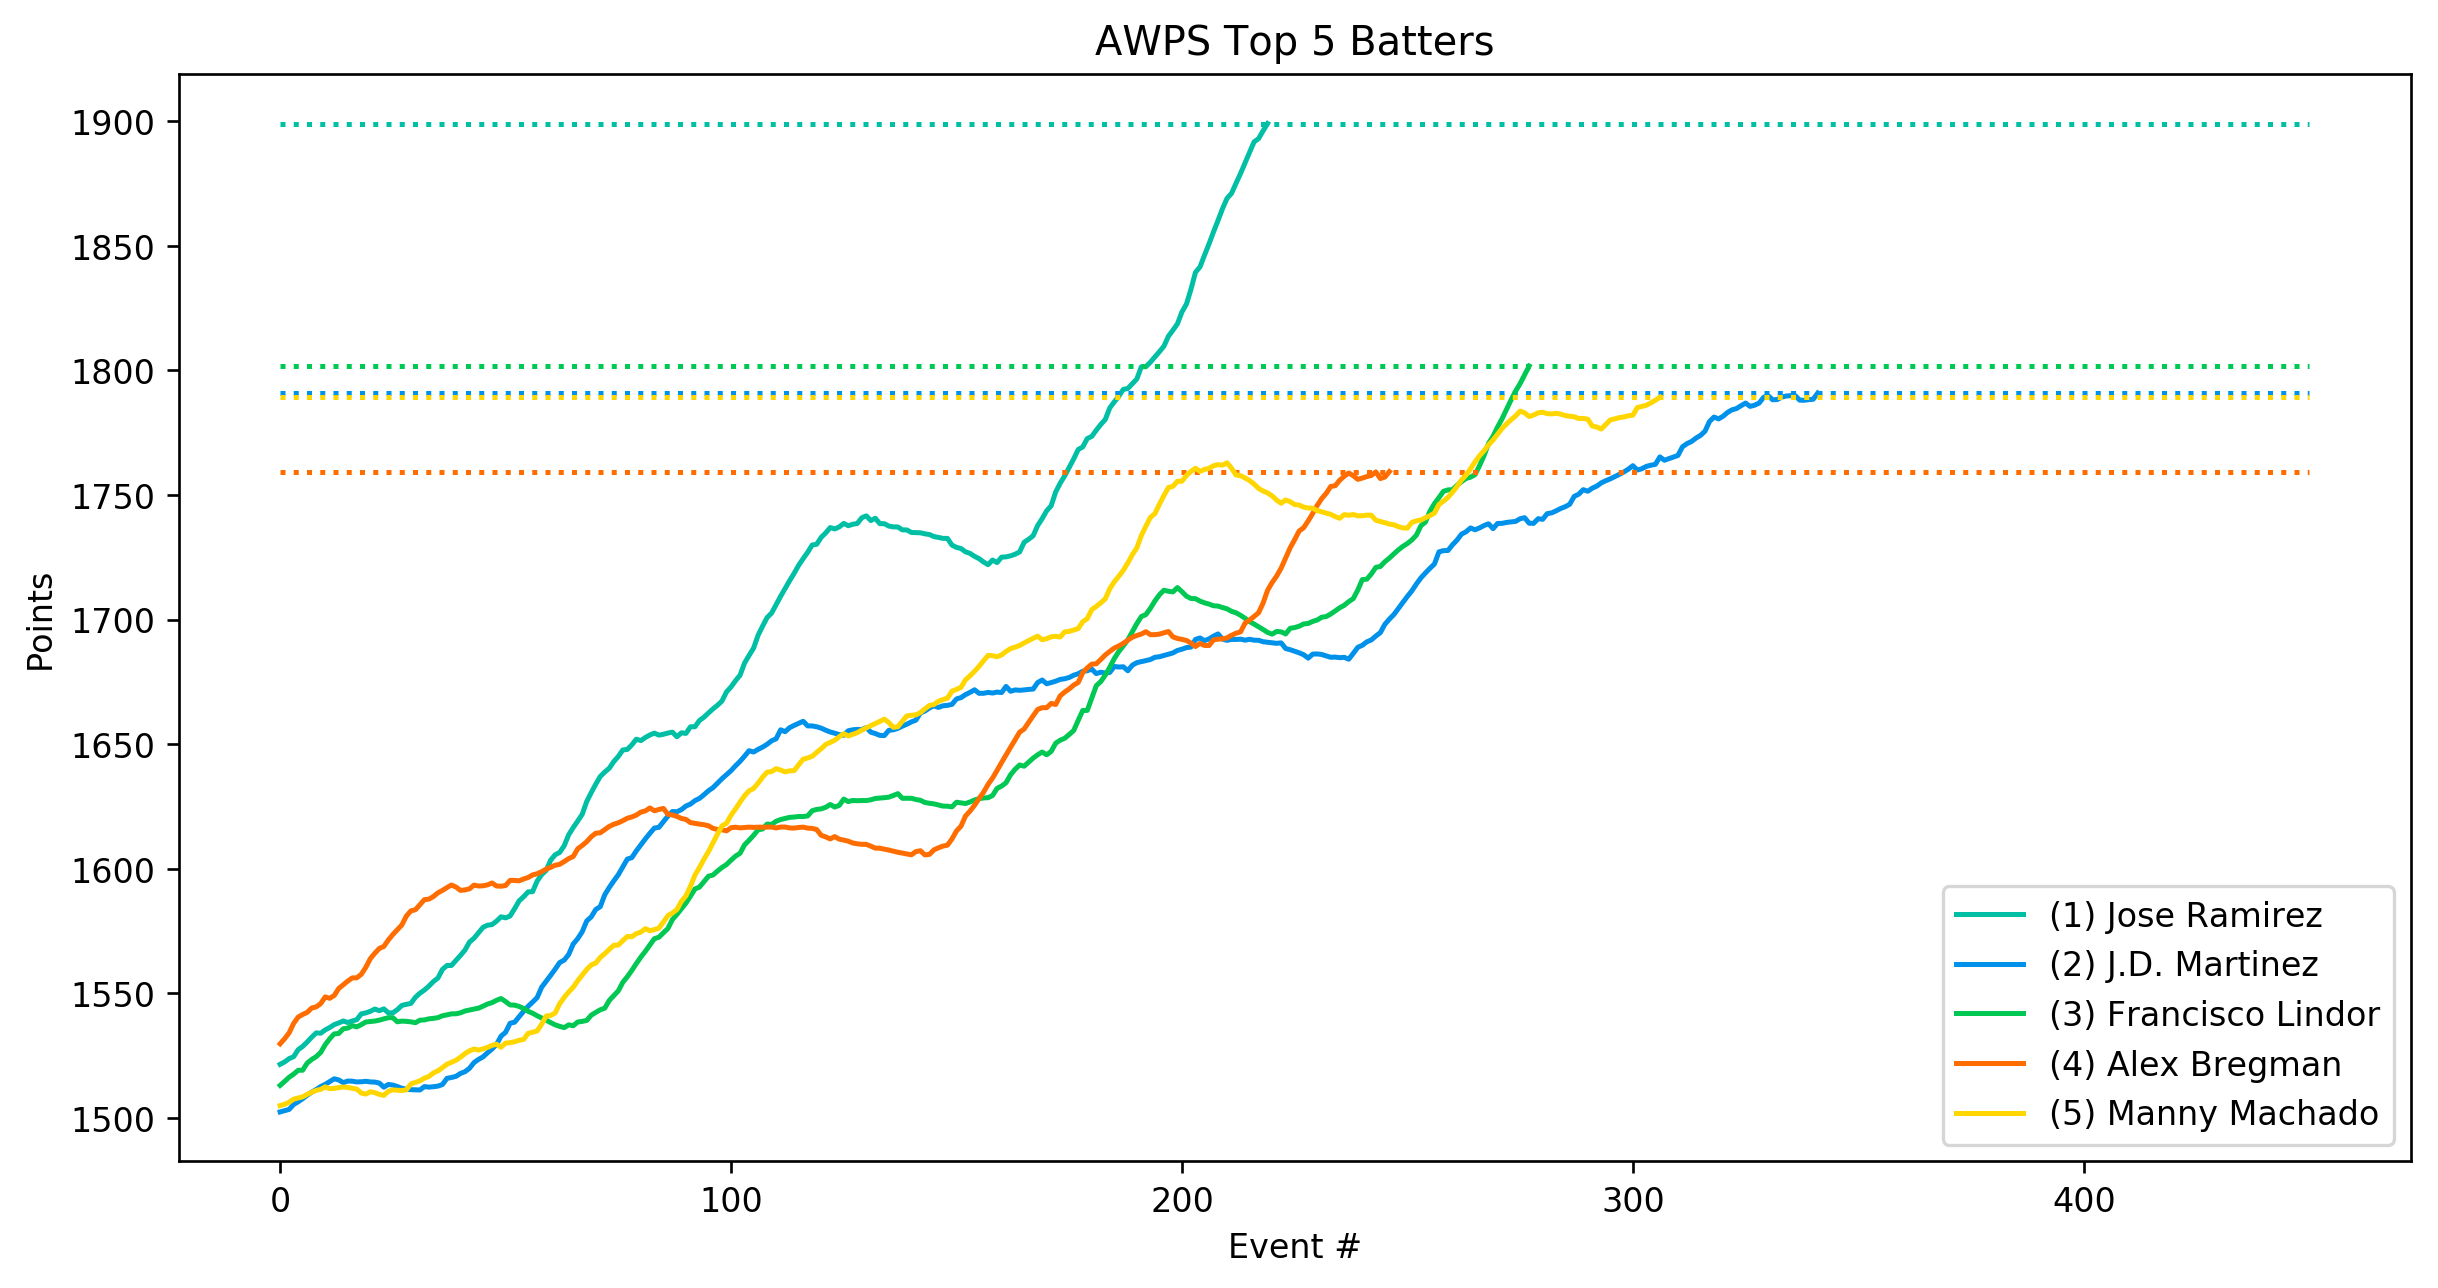

In [22]:
plt.figure(num=None, figsize=(12, 6), dpi=240, facecolor='w', edgecolor='k')
cmap = cm.get_cmap('winter', 12)(np.linspace(0, 1, 5))
for i in range(4, -1, -1):
    p = pitchers_sorted[-5:][i]
    rm = running_mean(pitchers[p[0]], window)
    plt.plot(rm, label='({}) {}'.format(str(5-i), player_map.get(p[0])), color=colors[i])
    plt.plot([0, 450], [rm[-1]]*2, color=colors[i], linestyle='dotted')
plt.legend()
plt.title('AWPS Top 5 Pitchers')
plt.xlabel('Event #')
plt.ylabel('Points')
plt.savefig(os.path.join(imgdir, 'AWPSTop5Pitchers'))

plt.show()

plt.figure(num=None, figsize=(12, 6), dpi=240, facecolor='w', edgecolor='k')
cmap = cm.get_cmap('winter', 12)(np.linspace(0, 1, 5))
for i in range(4, -1, -1):
    b = batters_sorted[-5:][i]
    rm = running_mean(batters[b[0]], window)
    plt.plot(rm, label='({}) {}'.format(str(5-i), player_map.get(b[0])), color=colors[i])
    plt.plot([0, 450], [rm[-1]]*2, color=colors[i], linestyle='dotted')
plt.legend()
plt.title('AWPS Top 5 Batters')
plt.xlabel('Event #')
plt.ylabel('Points')
plt.savefig(os.path.join(imgdir, 'AWPSTop5Batters'))
plt.show()

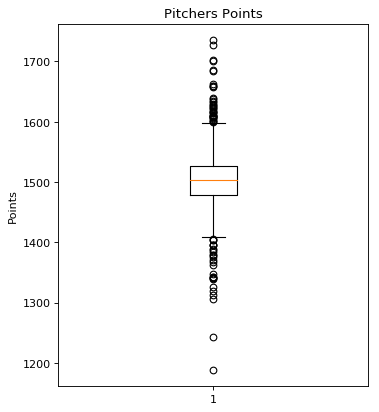

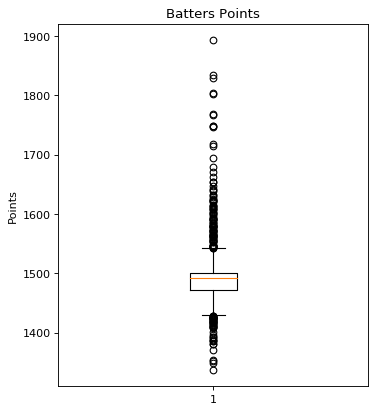

In [23]:
plt.figure(num=None, figsize=(5, 6), dpi=80, facecolor='w', edgecolor='k')
plt.boxplot(np.array(pitchers_sorted).transpose()[1])
plt.ylabel('Points')
plt.title('Pitchers Points')
plt.savefig(os.path.join(imgdir, 'BoxPlotPitchers2018'))
plt.show()

plt.figure(num=None, figsize=(5, 6), dpi=80, facecolor='w', edgecolor='k')
plt.ylabel('Points')
plt.title('Batters Points')
plt.boxplot(np.array(batters_sorted).transpose()[1])
plt.savefig(os.path.join(imgdir, 'BoxPlotBatters2018'))
plt.show()

# NOTES

+ Useful for looking what each column in statcast data is https://baseballsavant.mlb.com/csv-docs#events
+ Wiki on the Elo rating system https://en.wikipedia.org/wiki/Elo_rating_system